In [192]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

<h1> Prepare data </h1>

<h5> Load Excel file as dataframes </h5>

In [193]:
invoices = pd.read_excel('sales_original.xlsx', sheet_name = 'invoices')
assessment = pd.read_excel('sales_original.xlsx', sheet_name = 'assessment')
customers = pd.read_excel('sales_original.xlsx', sheet_name = 'customers')
products = pd.read_excel('sales_original.xlsx', sheet_name = 'products')
stock = pd.read_excel('sales_original.xlsx', sheet_name = 'stock')

We cleaned the individual dataframes for our SQL queries. <br>
But for the EDA, we want to use all of the data. Sometimes the dropped duplicate rows or null values may still hold important information. <br>

The way these dataframes were created was: each row in each excel spread corresponds to the same row in all the other spreads. <br>
So we will concatenate along the row axis.


In [194]:
merged_table = pd.concat([invoices, assessment, customers, products, stock], axis = 1)

In [195]:
merged_table.head(2)

,InvoiceNo,ASIN,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID,rating,review_count,ASIN,CustomerID,Country,ASIN,title,product_type,StockCode,ASIN
0,78536597,B07GWKDLGT,4,496.95,1987.80,2018-12-01,17,18011,4.6,1399,B07GWKDLGT,18011,Germany,B07GWKDLGT,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,B07GWKDLGT
1,78536597,B01MTLH408,4,39.99,159.96,2018-12-01,17,18011,4.6,289,B01MTLH408,18011,Germany,B01MTLH408,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,B01MTLH408


In [196]:
merged_table.columns

Index(['InvoiceNo', 'ASIN', 'Quantity', 'price', 'total_sale', 'invoice_date',
       'invoice_time', 'CustomerID', 'rating', 'review_count', 'ASIN',
       'CustomerID', 'Country', 'ASIN', 'title', 'product_type', 'StockCode',
       'ASIN'],
      dtype='object')

Drop duplicate columns

In [197]:
merged_table.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True])

In [198]:
merged_table = merged_table.loc[:, ~merged_table.columns.duplicated()]

In [199]:
merged_table.head(2)

,InvoiceNo,ASIN,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID,rating,review_count,Country,title,product_type,StockCode
0,78536597,B07GWKDLGT,4,496.95,1987.80,2018-12-01,17,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703
1,78536597,B01MTLH408,4,39.99,159.96,2018-12-01,17,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001


Relabel columns 

In [200]:
merged_table = merged_table.rename(columns = {'InvoiceNo': 'invoice_no', 'ASIN':'product_id', 'Quantity': 'quantity', 'price': 'unit_price', 
                                'CustomerID': 'customer_id', 'Country': 'country', 'title':'product_name', 'StockCode': 'stock_code'})

Combine "invoice_date" + "invoice_time" as "invoice_datetime"

In [201]:
merged_table['invoice_datetime'] = merged_table['invoice_date'] + merged_table['invoice_time'].astype('timedelta64[h]')
merged_table = merged_table.drop(['invoice_date', 'invoice_time'], axis = 1)

In [202]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00


In [203]:
# Add "day_of_week" column
merged_table['day_of_week'] = merged_table['invoice_datetime'].dt.dayofweek # 0 = Monday, 1 = Tuesday, etc.

# Add "month" column
merged_table['month'] = merged_table['invoice_datetime'].dt.month

# Add "hour" column
merged_table['hour'] = merged_table['invoice_datetime'].dt.hour

# Add "year" column
merged_table['year'] = merged_table['invoice_datetime'].dt.year

# Add "quarter" column
merged_table['quarter'] = merged_table['invoice_datetime'].dt.quarter


In [204]:
merged_table['invoice_date'] = merged_table['invoice_datetime'].dt.date

Save the dataframe as csv

In [205]:
merged_table.to_csv('merged_table', index = False)

<h3> EDA </h3>

In [267]:
merged_table = pd.read_csv('merged_table', parse_dates = ['invoice_datetime'])

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The dataframe contains data from Dec 2018 until Dec 2019. <br>
Since we will be studying monthly and quarterly trends too, we need to be studying complete years. <br>
So, for the following analysis, we will work only with the 2019 data.

In [268]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01


<h3> Customer buying pattern </h3>

<h4> Aggregated dataframes </h4>

Group by: 

day_of_week <br>
hour  <br>
month <br>
country


In [339]:
# Group by day of week
df_dow = merged_table[merged_table['year'] == 2019].groupby(['day_of_week']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})

df_dow['num_orders']=df_dow['invoice_no']['nunique']
df_dow['total_sale_mean']=df_dow['total_sale']['mean']
df_dow['total_revenue']=df_dow['total_sale']['sum']
df_dow['num_unique_customers']= df_dow['customer_id']['nunique']
df_dow['units_sold_mean'] = df_dow['quantity']['mean']
df_dow['total_units_sold'] = df_dow['quantity']['sum']

df_dow = df_dow[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_dow = df_dow.reset_index()

df_dow.loc['6'] = [1,0,0,0,0]
df_dow = df_dow.sort_values('day_of_week')
df_dow.index = [0,1,2,3,4,5,6]


# Group by hour
df_hour = merged_table[merged_table['year'] == 2019].groupby(['hour']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_hour['num_orders']=df_hour['invoice_no']['nunique']
df_hour['total_sale_mean']=df_hour['total_sale']['mean']
df_hour['total_revenue']=df_hour['total_sale']['sum']
df_hour['num_unique_customers']= df_hour['customer_id']['nunique']
df_hour['units_sold_mean'] = df_hour['quantity']['mean']
df_hour['total_units_sold'] = df_hour['quantity']['sum']

df_hour = df_hour[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_hour = df_hour.reset_index()


# Group by month
df_month = merged_table[merged_table['year'] == 2019].groupby(['month']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_month['num_orders']=df_month['invoice_no']['nunique']
df_month['total_sale_mean']=df_month['total_sale']['mean']
df_month['total_revenue']=df_month['total_sale']['sum']
df_month['num_unique_customers']= df_month['customer_id']['nunique']
df_month['units_sold_mean'] = df_month['quantity']['mean']
df_month['total_units_sold'] = df_month['quantity']['sum']

df_month = df_month[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_month = df_month.reset_index()

# Group by invoice_date
df_date = merged_table[merged_table['year'] == 2019].groupby(['invoice_date']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_date['num_orders']=df_date['invoice_no']['nunique']
df_date['total_sale_mean']=df_date['total_sale']['mean']
df_date['total_revenue']=df_date['total_sale']['sum']
df_date['num_unique_customers']= df_date['customer_id']['nunique']
df_date['units_sold_mean'] = df_date['quantity']['mean']
df_date['total_units_sold'] = df_date['quantity']['sum']

df_date = df_date[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_date = df_date.reset_index()


# Group by country
df_country = merged_table[merged_table['year'] == 2019].groupby(['country']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_country['num_orders']=df_country['invoice_no']['nunique']
df_country['total_sale_mean']=df_country['total_sale']['mean']
df_country['total_revenue']=df_country['total_sale']['sum']
df_country['num_unique_customers']= df_country['customer_id']['nunique']
df_country['units_sold_mean'] = df_country['quantity']['mean']
df_country['total_units_sold'] = df_country['quantity']['sum']

df_country = df_country[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_country.sort_values(by = ['total_revenue', 'num_orders', 'num_unique_customers'],ascending = False, inplace = True)
df_country['revenue_per_customer'] = df_country['total_revenue'] / df_country['num_unique_customers']
df_country['revenue_per_order'] = df_country['total_revenue'] / df_country['num_orders']
df_country = df_country.reset_index()

In [340]:
# Group by customer

df_customer = merged_table.groupby(['customer_id']).agg({'invoice_no':'nunique', 'total_sale':'sum', 
                                                    'product_id': 'nunique', 'unit_price':'mean',
                                                     'quantity': ['mean', 'sum']})

df_customer['num_orders'] = df_customer['invoice_no']['nunique']
df_customer['total_revenue'] = df_customer['total_sale']['sum']
df_customer['num_unique_products'] = df_customer['product_id']['nunique']
df_customer['avg_unit_price'] = df_customer['unit_price']['mean']
df_customer['total_units_sold'] = df_customer['quantity']['sum']


df_customer = df_customer[['num_orders','total_revenue','num_unique_products','avg_unit_price','total_units_sold']].reset_index().sort_values(by='total_revenue',ascending=False)
df_customer.drop(4339, axis = 0,inplace = True) # drop row where customer_id = Null
df_customer

,customer_id,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold
,,,,,,
1690,14646,73,21664738.30,707,96.933489,205535
1880,14911,201,9340224.33,1790,97.530018,83711
55,12415,20,9244349.18,442,106.143735,80119
3729,17450,46,9061246.11,123,97.376657,70185
4202,18102,60,8114485.22,162,123.187740,72321
...,...,...,...,...,...,...
353,12789,1,35.97,3,11.990000,3
2639,15940,1,31.96,1,7.990000,4
4325,18268,1,23.98,1,11.990000,2


In [341]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4339 entries, 1690 to 825
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (customer_id, )          4339 non-null   object 
 1   (num_orders, )           4339 non-null   int64  
 2   (total_revenue, )        4339 non-null   float64
 3   (num_unique_products, )  4339 non-null   int64  
 4   (avg_unit_price, )       4339 non-null   float64
 5   (total_units_sold, )     4339 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 237.3+ KB


The columns are currently tuples. Want to retrieve only 0th element of each tuple.

In [342]:
df_customer.columns = [tup[0] for tup in df_customer.columns]
df_customer.columns

Index(['customer_id', 'num_orders', 'total_revenue', 'num_unique_products',
       'avg_unit_price', 'total_units_sold'],
      dtype='object')

In [343]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4339 entries, 1690 to 825
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          4339 non-null   object 
 1   num_orders           4339 non-null   int64  
 2   total_revenue        4339 non-null   float64
 3   num_unique_products  4339 non-null   int64  
 4   avg_unit_price       4339 non-null   float64
 5   total_units_sold     4339 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 237.3+ KB


We also want to add the customer country to df_customer. Do a left join.

In [344]:
dummy = merged_table[['customer_id', 'country']].drop_duplicates()

In [345]:
df_customer = pd.merge(df_customer, dummy, on = 'customer_id', how = 'left', copy = False)

In [346]:
df_customer.head()

,customer_id,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold,country
0,14646,73,21664738.30,707,96.933489,205535,Netherlands
1,14911,201,9340224.33,1790,97.530018,83711,Ireland
2,12415,20,9244349.18,442,106.143735,80119,Australia
3,17450,46,9061246.11,123,97.376657,70185,Germany
4,18102,60,8114485.22,162,123.187740,72321,Germany


<h3> Check all aggragated dataframes </h3>

In [347]:
df_dow.head()


,day_of_week,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,0,3047,8.833007e+07,1497,906148
1,1,0,0.000000e+00,0,0
2,2,2052,4.848538e+07,1181,459617
3,3,2993,8.981944e+07,1525,894923
4,4,3430,1.143019e+08,1649,1154448


In [348]:
df_hour.head()


,hour,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,6,1,279.00,1,1
1,7,27,1411814.09,26,15773
2,8,542,16959489.24,415,162761
3,9,1412,50196824.30,845,515716
4,10,2252,80975107.94,1199,843607


In [349]:
df_month.head()


,month,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,1,1100,38126912.27,742,407747
1,2,1108,29315803.02,759,300844
2,3,1496,42474432.75,975,422550
3,4,1276,32697661.49,855,328131
4,5,1707,41226715.35,1057,428100


In [350]:
df_date.head()

,invoice_date,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,2019-01-04,39,1002201.60,35,9256
1,2019-01-05,55,1786655.03,46,20504
2,2019-01-06,50,2327005.04,46,24178
3,2019-01-07,53,2117371.08,46,17648
4,2019-01-09,48,1015109.82,48,8532


In [351]:
df_country.head()

,country,num_orders,total_revenue,num_unique_customers,total_units_sold,revenue_per_customer,revenue_per_order
,,,,,,,
0,Germany,17248,4.808830e+08,3815,4731881,1.260506e+05,27880.506213
1,Netherlands,91,2.130295e+07,8,202159,2.662869e+06,234098.389121
2,Ireland,271,1.539087e+07,4,147902,3.847717e+06,56792.869336
3,United Kingdom,448,1.178792e+07,101,126310,1.167120e+05,26312.312589
4,France,368,1.109539e+07,85,111131,1.305340e+05,30150.524429


In [352]:
df_customer.head()

,customer_id,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold,country
0,14646,73,21664738.30,707,96.933489,205535,Netherlands
1,14911,201,9340224.33,1790,97.530018,83711,Ireland
2,12415,20,9244349.18,442,106.143735,80119,Australia
3,17450,46,9061246.11,123,97.376657,70185,Germany
4,18102,60,8114485.22,162,123.187740,72321,Germany


six dataframes: <br>
dow, month, hour, date, country, customer_id <br>

<h3> Day of week </h3>

In [353]:
df_dow

,day_of_week,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,0,3047,8.833007e+07,1497,906148
1,1,0,0.000000e+00,0,0
2,2,2052,4.848538e+07,1181,459617
3,3,2993,8.981944e+07,1525,894923
4,4,3430,1.143019e+08,1649,1154448
5,5,3566,1.052957e+08,1652,1034159
6,6,3963,1.290344e+08,1901,1200525


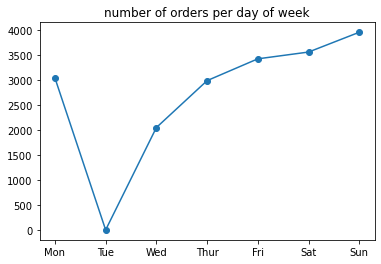

In [354]:
fig, ax = plt.subplots()
ax.plot(df_dow['day_of_week'], df_dow['num_orders'], marker = 'o')
ax.set_title('number of orders per day of week')
ax.set_xticks(list(range(7)))
ax.set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.show()

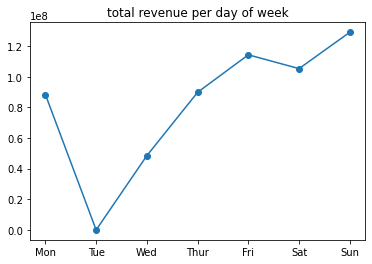

In [355]:
fig, ax = plt.subplots()
ax.plot(df_dow['day_of_week'], df_dow['total_revenue'], marker = 'o')
ax.set_title('total revenue per day of week')
ax.set_xticks(list(range(7)))
ax.set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.show()

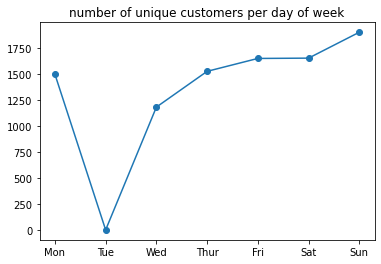

In [356]:
fig, ax = plt.subplots()
ax.plot(df_dow['day_of_week'], df_dow['num_unique_customers'], marker = 'o')
ax.set_title('number of unique customers per day of week')
ax.set_xticks(list(range(7)))
ax.set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.show()

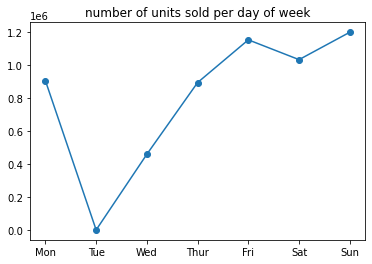

In [357]:
fig, ax = plt.subplots()
ax.plot(df_dow['day_of_week'], df_dow['total_units_sold'], marker = 'o')
ax.set_title('number of units sold per day of week')
ax.set_xticks(list(range(7)))
ax.set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.show()

<h3> Month </h3>

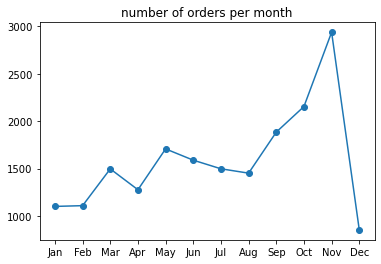

In [358]:
fig, ax = plt.subplots()
ax.plot(df_month['month'], df_month['num_orders'], marker = 'o')
ax.set_title('number of orders per month')
ax.set_xticks(list(range(1,13,1)))
ax.set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

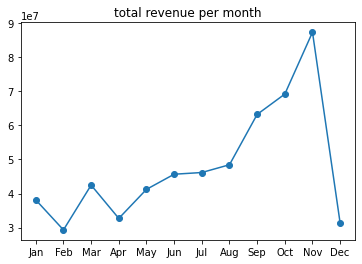

In [359]:
fig, ax = plt.subplots()
ax.plot(df_month['month'], df_month['total_revenue'], marker = 'o')
ax.set_title('total revenue per month')
ax.set_xticks(list(range(1,13,1)))
ax.set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

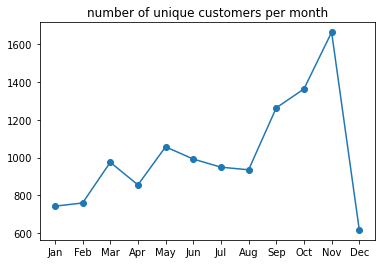

In [360]:
fig, ax = plt.subplots()
ax.plot(df_month['month'], df_month['num_unique_customers'], marker = 'o')
ax.set_title('number of unique customers per month')
ax.set_xticks(list(range(1,13,1)))
ax.set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

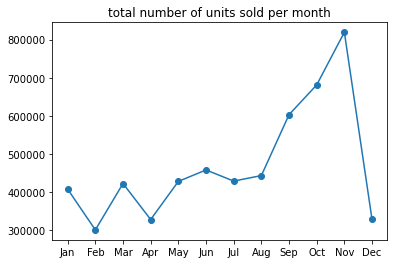

In [361]:
fig, ax = plt.subplots()
ax.plot(df_month['month'], df_month['total_units_sold'], marker = 'o')
ax.set_title('total number of units sold per month')
ax.set_xticks(list(range(1,13,1)))
ax.set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

<h3> Hour </h3>

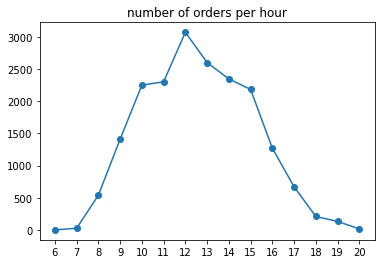

In [363]:
fig, ax = plt.subplots()
ax.plot(df_hour['hour'], df_hour['num_orders'], marker = 'o')
ax.set_title('number of orders per hour')
ax.set_xticks(ticks = list(range(6,21,1)))
ax.set_xticklabels(labels = list(range(6,21,1)))
plt.show()

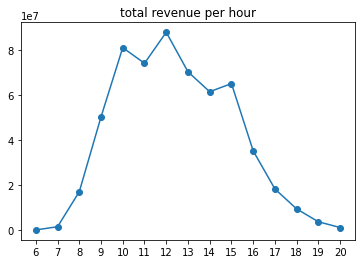

In [364]:
fig, ax = plt.subplots()
ax.plot(df_hour['hour'], df_hour['total_revenue'], marker = 'o')
ax.set_title('total revenue per hour')
ax.set_xticks(ticks = list(range(6,21,1)))
ax.set_xticklabels(labels = list(range(6,21,1)))
plt.show()

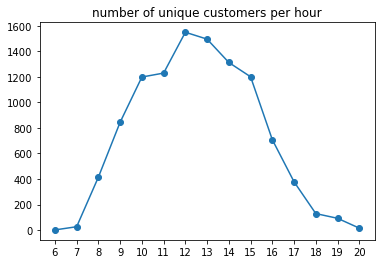

In [365]:
fig, ax = plt.subplots()
ax.plot(df_hour['hour'], df_hour['num_unique_customers'], marker = 'o')
ax.set_title('number of unique customers per hour')
ax.set_xticks(ticks = list(range(6,21,1)))
ax.set_xticklabels(labels = list(range(6,21,1)))
plt.show()

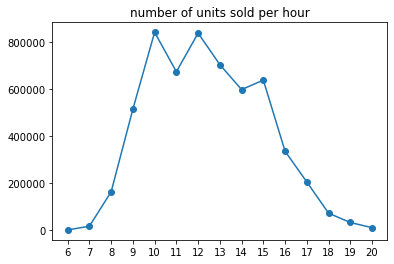

In [366]:
fig, ax = plt.subplots()
ax.plot(df_hour['hour'], df_hour['total_units_sold'], marker = 'o')
ax.set_title('number of units sold per hour')
ax.set_xticks(ticks = list(range(6,21,1)))
ax.set_xticklabels(labels = list(range(6,21,1)))
plt.show()

<h3> Invoice date </h3>

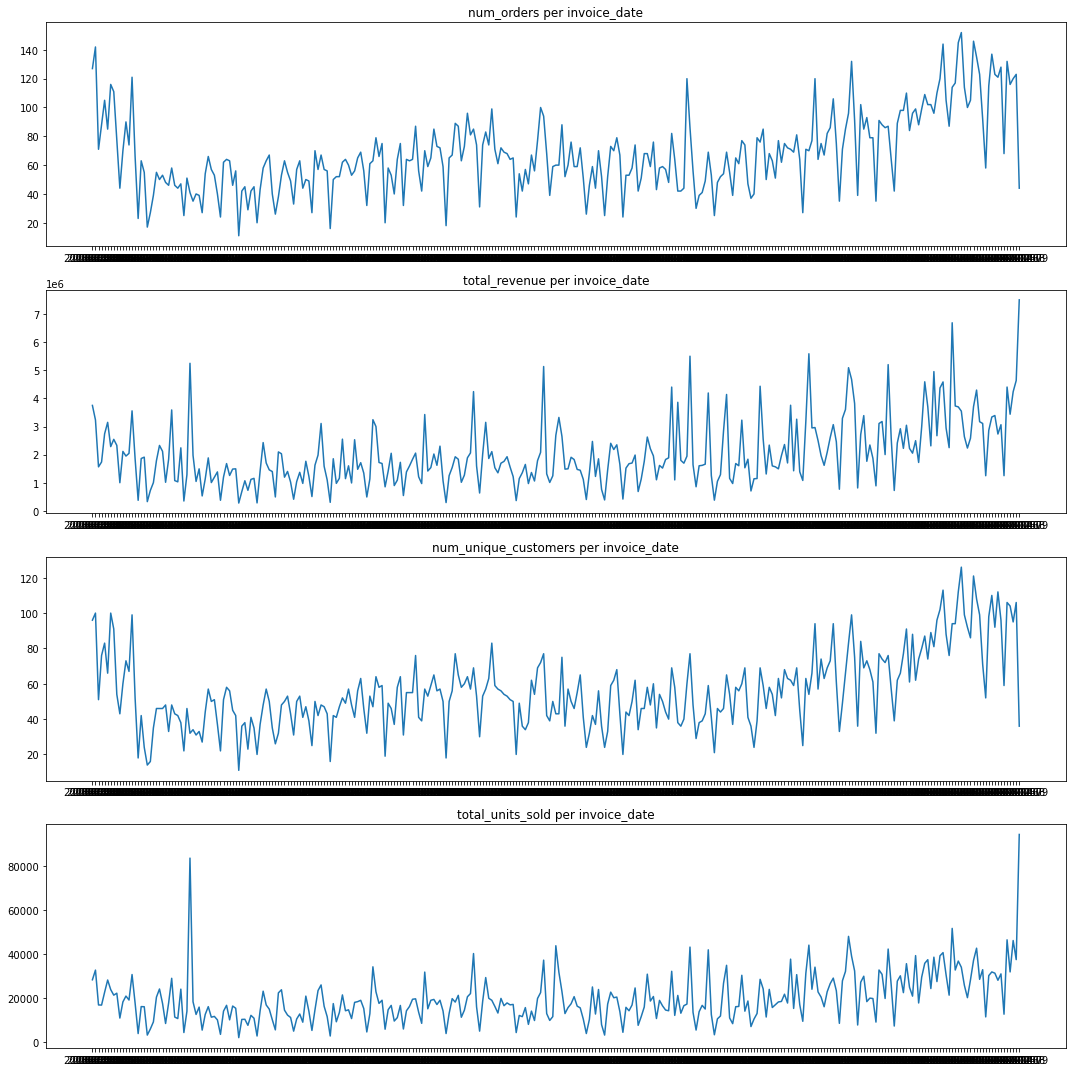

In [299]:
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (15,15))
for i, var in enumerate (variables):
    ax[i].plot(df_date['invoice_date'], df_date[var])
    ax[i].set_title (f'{var} per invoice_date')
    
plt.tight_layout()
plt.show()



<h3> Days in 2019 with unusual peaks and troughs in total_revenue </h3>

In [369]:
df_date.head()

,invoice_date,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,2019-01-04,39,1002201.60,35,9256
1,2019-01-05,55,1786655.03,46,20504
2,2019-01-06,50,2327005.04,46,24178
3,2019-01-07,53,2117371.08,46,17648
4,2019-01-09,48,1015109.82,48,8532


To locate unusual peaks: <br>
Add column for the "rolling mean" and column for "total revenue - rolling mean"

In [377]:
df_date ['total_revenue_rolling_mean'] = df_date['total_revenue'].rolling(5, center= True).mean()       # mean of current date + previous date + following date
df_date['total_revenue_minus_mean'] = df_date ['total_revenue'] - df_date ['total_revenue_rolling_mean'] # current value - mean value

In [378]:
# Convert invoice_date column to datetime format
df_date['invoice_date'] = pd.to_datetime(df_date['invoice_date'])

In [406]:
# Select unusual peaks and troughs
high_rev_dates = df_date[(df_date['total_revenue_rolling_mean']!= 'NaN')&(df_date['total_revenue_minus_mean']/df_date['total_revenue_rolling_mean']>0.3)] 
low_rev_dates = df_date[(df_date['total_revenue_rolling_mean']!= 'NaN')&(df_date['total_revenue_minus_mean']/df_date['total_revenue_rolling_mean']<-0.3)]

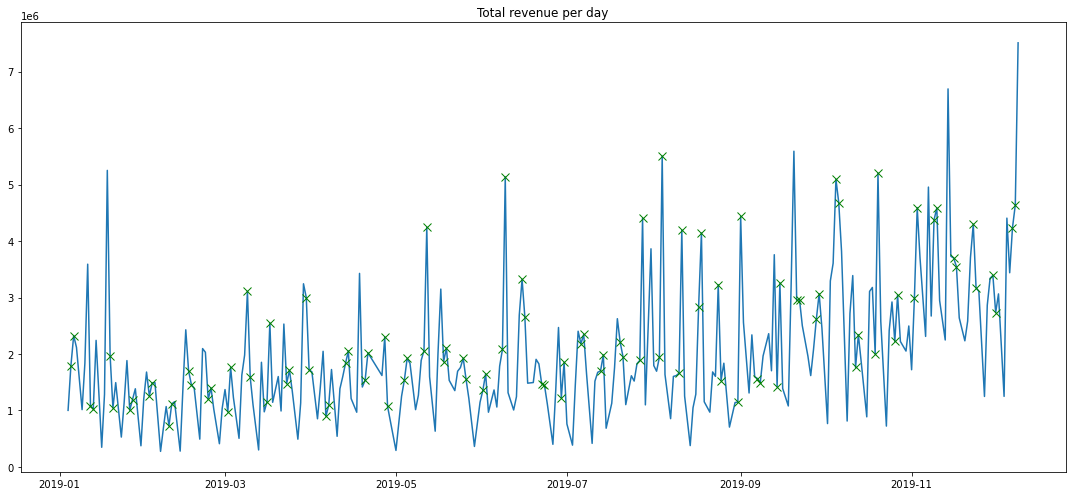

In [419]:
x = high_rev_dates ['invoice_date']
y = high_rev_dates ['total_revenue']

a = low_rev_dates ['invoice_date']
b = low_rev_dates ['total_revenue']

m = weekends_2019['invoice_date']
n = weekends_2019['total_revenue']


df_date_2019 = df_date [df_date['invoice_date'].dt.year == 2019]

plt.figure(figsize = (15,7))
plt.plot (df_date_2019['invoice_date'], df_date_2019['total_revenue'], label = 'revenue')
# for xy in zip (x,y):
#     plt.plot(xy[0], xy[1], color = 'r', marker = 'o', label = 'high rev', alpha = 0.8)
#     #plt.annotate(f'{xy[0].strftime("%d-%b")}', xy = xy)

# for ab in zip (a,b):
#     plt.plot(ab[0], ab[1], color = 'b', marker = 'o', alpha = 0.8)
#     #plt.annotate(f'{ab[0].strftime("%d-%b")}', xy = ab)

for mn in zip (m,n):
    plt.plot(mn[0], mn[1], color = 'g', marker='x', markersize = 8, label = 'weekends')
    
plt.title('Total revenue per day')
plt.tight_layout()
plt.show()

<h3> Group by product </h3>

In [422]:
top_products = merged_table.groupby('product_id')['quantity', 'total_sale'].sum().reset_index().sort_values(by = 'total_sale', ascending = False)
top_products.drop(top_products [top_products['product_id'] == 'Null'].index, inplace = True)
top_products['unit_price'] = top_products['total_sale'] / top_products['quantity']
top_products.head(10)

product_names = merged_table.drop_duplicates(subset = ['product_id', 'product_name', 'product_type'])
product_names = product_names[['product_id','product_name', 'product_type']]

top_products = pd.merge(top_products, product_names, on = 'product_id', how = 'left')
top_products

/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/614824308.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top_products = merged_table.groupby('product_id')['quantity', 'total_sale'].sum().reset_index().sort_values(by = 'total_sale', ascending = False)


,product_id,quantity,total_sale,unit_price,product_name,product_type
0,B079JSZ1Z2,48478,27327048.60,563.70,Samsung Galaxy S9 G960U 64GB Unlocked 4G LTE P...,smartphone
1,B081TJ7B88,37895,19288555.00,509.00,"Apple iPhone X, 256GB, Silver - Fully Unlocked...",smartphone
2,B07NZX5BKH,13890,9271575.00,667.50,Samsung Galaxy S10+ Plus 128GB+8GB RAM SM-G975...,smartphone
3,B07598VZR8,26339,9217596.44,349.96,Intel Core i7-8700K Desktop Processor 6 Cores ...,processor
4,B00009R6WO,13882,9009418.00,649.00,Canon EF 17-40mm f/4L USM Ultra Wide Angle Zoo...,dslr camera
...,...,...,...,...,...,...
4305,B01J3DVRFG,1,7.99,7.99,kwmobile TPU Silicone Case Compatible with LG ...,smartphone
4306,B07N496KJ4,1,7.99,7.99,kwmobile TPU Silicone Case Compatible with Hua...,smartphone
4307,B07BGQYWWQ,1,7.98,7.98,"Moto G6 Play Case,Moto G6 Forge case, Suensan ...",smartphone
4308,B07JL6G69Q,1,6.88,6.88,"Keyboard Cover Design for 17.3"" Envy 17M 17M-A...",keyboard


<h3> Top N revenue generating products </h3>

In [325]:
N = 20
top_products.sort_values(by = 'total_sale', ascending = False).head(N)

,product_id,quantity,total_sale,unit_price,product_name,product_type
0,B079JSZ1Z2,48478,27327048.60,563.70,Samsung Galaxy S9 G960U 64GB Unlocked 4G LTE P...,smartphone
1,B081TJ7B88,37895,19288555.00,509.00,"Apple iPhone X, 256GB, Silver - Fully Unlocked...",smartphone
2,B07NZX5BKH,13890,9271575.00,667.50,Samsung Galaxy S10+ Plus 128GB+8GB RAM SM-G975...,smartphone
3,B07598VZR8,26339,9217596.44,349.96,Intel Core i7-8700K Desktop Processor 6 Cores ...,processor
4,B00009R6WO,13882,9009418.00,649.00,Canon EF 17-40mm f/4L USM Ultra Wide Angle Zoo...,dslr camera
5,B07BFNDPJ5,17608,8557311.92,485.99,(Renewed) Latest Microsoft Surface Pro 4 (2736...,processor
6,B07Y8Y6HVW,36461,7802654.00,214.00,"Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LT...",smartphone
7,B01M4II4M4,18299,7301301.00,399.00,ASUS ROG Swift PG248Q 24â€ Gaming Monitor Ful...,monitor
8,B07TWFWJDZ,36419,7245560.05,198.95,Fitbit Versa 2 Health and Fitness Smartwatch w...,smartphone
9,B087RTV311,11656,6410683.44,549.99,"Acer Aspire 5 A515-55-56VK, 15.6"" Full HD IPS ...",keyboard


<h3> Top N selling products (by units sold) </h3>

In [326]:
N = 20
top_products.sort_values(by = 'quantity', ascending = False).head(N)

,product_id,quantity,total_sale,unit_price,product_name,product_type
11,B019PX7EGK,80995,6146710.55,75.89,CPB Heating Pad Compatible with iPad iPhone Sm...,smartphone
14,B07D99KFPL,78033,4661691.42,59.74,Seagate BarraCuda Pro 1TB Internal Hard Drive ...,processor
201,B081RF4VLM,55047,607718.88,11.04,"Adjustable Cell Phone Stand, Lamicall Phone St...",smartphone
0,B079JSZ1Z2,48478,27327048.60,563.70,Samsung Galaxy S9 G960U 64GB Unlocked 4G LTE P...,smartphone
101,B07Y693ND1,38706,1160792.94,29.99,Razer DeathAdder Essential Gaming Mouse: 6400 ...,mouse
100,B07Y693ND1,38706,1160792.94,29.99,Razer DeathAdder Essential Gaming Mouse: 6400 ...,keyboard
1,B081TJ7B88,37895,19288555.00,509.00,"Apple iPhone X, 256GB, Silver - Fully Unlocked...",smartphone
161,B00D76RNLS,36761,769407.73,20.93,"Manfrotto PIXI Mini Tripod, Black (MTPIXI-B)",dslr camera
6,B07Y8Y6HVW,36461,7802654.00,214.00,"Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LT...",smartphone
8,B07TWFWJDZ,36419,7245560.05,198.95,Fitbit Versa 2 Health and Fitness Smartwatch w...,smartphone
